# Exploratory analysis on conversational tweets

In this dataset, we extract all the conversations for three popular users

- MashiRafael (politics)
- aguschmer (sports)

- KarlaMoralesR (activism on humanitarian aid)

In [69]:
%matplotlib inline
import matplotlib.pyplot as plt
import pandas as pd
from tqdm import tqdm
from os import listdir
from os.path import isfile, join
import os
import csv
import numpy as np
import networkx as nx
import numpy as np
import json

In [12]:
data_dir='~/data/twconv/twconv_2016_usersec'
data_dir=os.path.expanduser(data_dir)
fpath = os.path.join(data_dir, 'conversations_large.csv')
ds = pd.read_csv(fpath, parse_dates=['timestamp'])
ds.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 520263 entries, 0 to 520262
Data columns (total 14 columns):
id                       520263 non-null int64
screen_name              520263 non-null object
latitude                 4063 non-null float64
longitude                4063 non-null float64
lang                     520263 non-null object
in_reply_to_status_id    507354 non-null float64
created_at               520263 non-null object
text                     520263 non-null object
timestamp                520247 non-null datetime64[ns]
conversation_id          520263 non-null int64
conversation_deep        520263 non-null int64
num_replies              520263 non-null int64
num_users                520263 non-null int64
url                      520263 non-null object
dtypes: datetime64[ns](1), float64(3), int64(5), object(5)
memory usage: 55.6+ MB


In [13]:
conv_users = ds[ds.in_reply_to_status_id.isnull()].groupby('screen_name')
conv_users.size().sort_values(ascending=False).head()

screen_name
aguschmer        5257
MashiRafael      5060
KarlaMoralesR    1768
adeljar            11
la_abogada_        11
dtype: int64

In [14]:
print(conv_users.size().shape[0])

652


In [15]:
participants_by_conv_starter = []
pcs = {}

for name, group in conv_users:
    conv_ids = group.id.values
    conv_tweets = ds[ds.conversation_id.isin(conv_ids)]
    participants_by_conv_starter.append((name, conv_tweets.shape[0], conv_tweets.screen_name.nunique()))
    pcs[name] = set(conv_tweets.screen_name.unique())

ds_participants = pd.DataFrame(participants_by_conv_starter, columns=['screen_name','num_replies','num_participants'])
ds_participants.sort_values(by='num_replies', ascending=False).head()

,screen_name,num_replies,num_participants
208,MashiRafael,413805,97682
326,aguschmer,79425,24219
173,KarlaMoralesR,12355,5290
36,BatichicaRC,489,207
579,pametroya,393,157


## users participating on conversations in different domains?

In [16]:
intersect = pcs['MashiRafael'].intersection(pcs['aguschmer'])
intersect2 = pcs['MashiRafael'].intersection(pcs['KarlaMoralesR'])
intersect3 = pcs['aguschmer'].intersection(pcs['KarlaMoralesR'])
print(len(intersect))
print(len(intersect2))
print(len(intersect3))

7699
2138
1945


In [17]:
(7699+2138+1945) / ds.screen_name.nunique()

0.09953451436584974

less than 10% of the total of the users

In [64]:
name_list=['MashiRafael','KarlaMoralesR','aguschmer']
color_list=['green', 'red', 'blue']
nodes_color = []
i = 0
G = nx.DiGraph()

group_id=0
for name, color in zip(name_list, color_list):
    nodes = list(pcs[name])
    sample_nodes=np.random.choice(nodes, int(len(nodes)*0.01),replace=False)
    G.add_node(name, group=group_id, text=name, r=8)
    for e in sample_nodes:
        G.add_node(e, group=group_id, text='', r=3)
        G.add_edge(e, name)
    group_id+=1
        
        
name_list= []
name_list.append(('MashiRafael','aguschmer'))
name_list.append(('MashiRafael','KarlaMoralesR'))
name_list.append(('aguschmer','KarlaMoralesR'))

node_list = []
node_list.append(intersect)
node_list.append(intersect2)
node_list.append(intersect3)
intergroup = []

for names, nodes_ in zip(name_list, node_list):
    nodes = list(nodes_)
    sample_nodes = np.random.choice(nodes, int(len(nodes)*0.05), replace=False)

    for e in sample_nodes:
        G.add_node(e, group=group_id, text='', r=3)
        G.add_edge(e, names[0])
        G.add_edge(e, names[1])
        intergroup.append(e)
        
for name in ['MashiRafael','KarlaMoralesR','aguschmer']:
    G.nodes[name]['r'] = 8

In [67]:
nodes = [{'id': k, 'group':att['group'], 'text':att['text'], 'r':att['r']} for k,att in G.nodes(data=True)]
links = []
for source, target in  G.edges:
    links.append({'source':source, 'target':target, 'value':1})
rep = {'nodes': nodes, 'links': links}

with open('usernetwork.json', 'w') as f:
    json.dump(rep, f)    

In [68]:
ucount={}
for source, target in  G.edges:
    ucount[target] = 1 if target not in ucount else ucount[target]+1
ucount

{'MashiRafael': 1459, 'aguschmer': 720, 'KarlaMoralesR': 251}

{'MashiRafael': Text(-0.4379064738750458, -0.14499527215957642, 'MashiRafael'),
 'KarlaMoralesR': Text(-0.14877204596996307, 0.7309276461601257, 'KarlaMoralesR'),
 'aguschmer': Text(0.9550588726997375, 0.013561973348259926, 'aguschmer')}

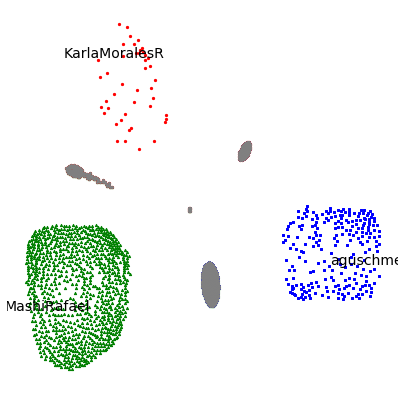

In [44]:
plt.figure
fig, ax = plt.subplots(figsize=(7,7))
ax.axis('off')
pos = nx.spring_layout(G,k=0.10 , iterations=50)  #so^>v<dph8 ,k=0.10,iterations=50
group = list(G.predecessors('MashiRafael'))
nx.draw_networkx_nodes(G,pos=pos, with_labels=False,node_size=5, ax=ax, nodelist=group, node_color='green', node_shape='^')
group = list(G.predecessors('aguschmer'))
nx.draw_networkx_nodes(G,pos=pos, with_labels=False,node_size=5, ax=ax, nodelist=group, node_color='blue', node_shape='s')
group = list(G.predecessors('KarlaMoralesR'))
nx.draw_networkx_nodes(G,pos=pos, with_labels=False,node_size=5, ax=ax, nodelist=group, node_color='red', node_shape='o')

nx.draw_networkx_nodes(G,pos=pos, with_labels=False,node_size=5, ax=ax, nodelist=intergroup, node_color='grey', node_shape='8')

group=['MashiRafael','KarlaMoralesR','aguschmer']
labels = {name:name for name in group}
nx.draw_networkx_labels(G,pos,labels,font_size=14,font_color='black')